# Covid-19-Trend-Predictor
#### Prediction of number of Covid-19 cases in India for the next 15 days using LSTM
[Github-Repository](https://github.com/abdulsmapara/Covid-19-Trend-Predictor)


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


#### Preparing data
1. Features are scaled in suitable range
2. Data prepared for different countries differently (to prepare time-series indexed by date for each)

In [3]:
# data
df = pd.read_csv('../Timeseries-Data/timeseries_data.csv')
columns_to_keep = ['Date','Index','Location','Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df = df.astype({"Population_Density":float ,"Lockdown": float,'Num_Cases':float})
df = df[columns_to_keep]
numeric_columns = ['Population_Density','Lockdown','Max_Temp','Min_Temp','Num_Cases']
df_numeric = df[numeric_columns]
df_temp = df[['Min_Temp','Max_Temp']]
final_temp = []
df_numeric.head()
print('Min', np.min(df_numeric))
print('Max', np.max(df_numeric))
dataset = df_numeric.astype('float64')
# scaling
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaled_data = scaler.fit_transform(dataset)
temp_deno = (np.max(df['Max_Temp']) - np.min(df['Min_Temp']))
temp_num = np.min(df['Min_Temp'])
for ind in df['Index']:
    index = int(ind)
    df.at[index,'Population_Density'] = scaled_data[index][0]
    df.at[index,'Lockdown'] = scaled_data[index][1]
    df.at[index,'Min_Temp'] = (df.at[index,'Min_Temp'] - temp_num)/ temp_deno
    df.at[index,'Max_Temp'] = (df.at[index,'Max_Temp'] - temp_num)/ temp_deno
df = df.set_index("Date")
df_final = []
df_final.append(df[df.Location=='Australia'].reset_index(drop=True))
df_final.append(df[df.Location == 'India'].reset_index(drop=True))
df_final.append(df[df.Location == 'China'].reset_index(drop=True))
df_final.append(df[df.Location == 'USA'].reset_index(drop=True))
df_final.append(df[df.Location == 'Italy'].reset_index(drop=True))
df_final.append(df[df.Location == 'France'].reset_index(drop=True))
for df_temp in df_final:
    i=0
    for ind in df_temp['Index']:
        df_temp.at[i,'Index'] = i
        i+=1
    for ind in reversed(df_temp['Index']):
        i = int(ind)
        if i != 0:
            df_temp.at[i,'Num_Cases'] -= df_temp.at[i-1,'Num_Cases']
    df_temp['Num_Cases'] /= 1500
df_final[1]

Min Population_Density    9.0
Lockdown              0.0
Max_Temp              5.0
Min_Temp             -8.0
Num_Cases             0.0
dtype: float64
Max Population_Density      1202.0
Lockdown                 100.0
Max_Temp                  40.0
Min_Temp                  26.0
Num_Cases             187321.0
dtype: float64


,Index,Location,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
0,0.0,India,1.0,0.479167,0.645833,0.0,0.000000
1,1.0,India,1.0,0.437500,0.583333,0.0,0.000000
2,2.0,India,1.0,0.416667,0.625000,0.0,0.000000
3,3.0,India,1.0,0.500000,0.625000,0.0,0.000000
4,4.0,India,1.0,0.458333,0.645833,0.0,0.000000
5,5.0,India,1.0,0.458333,0.645833,0.0,0.000000
6,6.0,India,1.0,0.479167,0.562500,0.0,0.000000
7,7.0,India,1.0,0.458333,0.625000,0.0,0.000000
8,8.0,India,1.0,0.458333,0.604167,0.0,0.000667
9,9.0,India,1.0,0.479167,0.604167,0.0,0.000000


In [4]:
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']

for i in range(len(df_final)):
    df_final[i] = df_final[i][columns_input]

In [5]:
# df_India=df_India.set_index('Date')
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
# input_data = df_India[columns_input]
# output_data = df_India['Num_Cases']
# X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.304761, random_state = 1)
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
df_India = df_final[1][columns_input]
new_df_India = series_to_supervised(df_India,7,1,True)
# new_df.drop(new_df.columns[[-2,-3,-4,-5]], axis=1, inplace=True)

df_China = series_to_supervised(df_final[2],7,1,True)
df_Australia = series_to_supervised(df_final[0],7,1,True)
df_USA= series_to_supervised(df_final[3],7,1,True)
df_Italy=series_to_supervised(df_final[4],7,1,True)
df_France=series_to_supervised(df_final[5],7,1,True)
new_df_India

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
7,1.0,0.479167,0.645833,0.0,0.000000,1.0,0.437500,0.583333,0.0,0.000000,...,1.0,0.479167,0.562500,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000
8,1.0,0.437500,0.583333,0.0,0.000000,1.0,0.416667,0.625000,0.0,0.000000,...,1.0,0.458333,0.625000,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000667
9,1.0,0.416667,0.625000,0.0,0.000000,1.0,0.500000,0.625000,0.0,0.000000,...,1.0,0.458333,0.604167,0.0,0.000667,1.0,0.479167,0.604167,0.0,0.000000
10,1.0,0.500000,0.625000,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000,...,1.0,0.479167,0.604167,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000000
11,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000,...,1.0,0.458333,0.604167,0.0,0.000000,1.0,0.479167,0.645833,0.0,0.000667
12,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.479167,0.562500,0.0,0.000000,...,1.0,0.479167,0.645833,0.0,0.000667,1.0,0.479167,0.687500,0.0,0.000667
13,1.0,0.479167,0.562500,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000,...,1.0,0.479167,0.687500,0.0,0.000667,1.0,0.500000,0.625000,0.0,0.000000
14,1.0,0.458333,0.625000,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000667,...,1.0,0.500000,0.625000,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000
15,1.0,0.458333,0.604167,0.0,0.000667,1.0,0.479167,0.604167,0.0,0.000000,...,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.479167,0.666667,0.0,0.000000
16,1.0,0.479167,0.604167,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000000,...,1.0,0.479167,0.666667,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000


In [65]:
from numpy import concatenate
split_train = 63
values = df_Australia.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
model = Sequential()
model.add(LSTM(55, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
num_epochs = 889
# fit network
batch_size=None
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)

# # fit network
values = df_China.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)

# # fit network
values = df_France.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)

# # fit network
values = df_USA.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)

# # fit network
values = df_Italy.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)

# # fit network
values = new_df_India.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2, shuffle=False)


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 55)                20900     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 56        
Total params: 20,956
Trainable params: 20,956
Non-trainable params: 0
_________________________________________________________________
Epoch 1/889
 - 0s - loss: 0.0121
Epoch 2/889
 - 0s - loss: 0.0093
Epoch 3/889
 - 0s - loss: 0.0084
Epoch 4/889
 - 0s - loss: 0.0077
Epoch 5/889
 - 0s - loss: 0.0068
Epoch 6/889
 - 0s - loss: 0.0059
Epoch 7/889
 - 0s - loss: 0.0050
Epoch 8/889
 - 0s - loss: 0.0044
Epoch 9/889
 - 0s - loss: 0.0040
Epoch 10/889
 - 0s - loss: 0.0037
Epoch 11/889
 - 0s - loss: 0.0035
Epoch 12/889
 - 0s - loss: 0.0034
Epoch 13/889
 - 0s - loss: 0.0034
Epoch 14/889
 - 0s - loss: 0.0033
Epoch 15/889
 - 0s - loss: 0.0033
Epoch 16/8

Epoch 206/889
 - 0s - loss: 2.3306e-04
Epoch 207/889
 - 0s - loss: 2.3166e-04
Epoch 208/889
 - 0s - loss: 2.3027e-04
Epoch 209/889
 - 0s - loss: 2.2891e-04
Epoch 210/889
 - 0s - loss: 2.2756e-04
Epoch 211/889
 - 0s - loss: 2.2623e-04
Epoch 212/889
 - 0s - loss: 2.2491e-04
Epoch 213/889
 - 0s - loss: 2.2361e-04
Epoch 214/889
 - 0s - loss: 2.2233e-04
Epoch 215/889
 - 0s - loss: 2.2106e-04
Epoch 216/889
 - 0s - loss: 2.1981e-04
Epoch 217/889
 - 0s - loss: 2.1857e-04
Epoch 218/889
 - 0s - loss: 2.1734e-04
Epoch 219/889
 - 0s - loss: 2.1613e-04
Epoch 220/889
 - 0s - loss: 2.1494e-04
Epoch 221/889
 - 0s - loss: 2.1376e-04
Epoch 222/889
 - 0s - loss: 2.1259e-04
Epoch 223/889
 - 0s - loss: 2.1144e-04
Epoch 224/889
 - 0s - loss: 2.1030e-04
Epoch 225/889
 - 0s - loss: 2.0917e-04
Epoch 226/889
 - 0s - loss: 2.0805e-04
Epoch 227/889
 - 0s - loss: 2.0695e-04
Epoch 228/889
 - 0s - loss: 2.0586e-04
Epoch 229/889
 - 0s - loss: 2.0478e-04
Epoch 230/889
 - 0s - loss: 2.0371e-04
Epoch 231/889
 - 0s - los

 - 0s - loss: 1.0800e-04
Epoch 417/889
 - 0s - loss: 1.0776e-04
Epoch 418/889
 - 0s - loss: 1.0751e-04
Epoch 419/889
 - 0s - loss: 1.0726e-04
Epoch 420/889
 - 0s - loss: 1.0702e-04
Epoch 421/889
 - 0s - loss: 1.0678e-04
Epoch 422/889
 - 0s - loss: 1.0654e-04
Epoch 423/889
 - 0s - loss: 1.0630e-04
Epoch 424/889
 - 0s - loss: 1.0606e-04
Epoch 425/889
 - 0s - loss: 1.0582e-04
Epoch 426/889
 - 0s - loss: 1.0558e-04
Epoch 427/889
 - 0s - loss: 1.0535e-04
Epoch 428/889
 - 0s - loss: 1.0511e-04
Epoch 429/889
 - 0s - loss: 1.0488e-04
Epoch 430/889
 - 0s - loss: 1.0464e-04
Epoch 431/889
 - 0s - loss: 1.0441e-04
Epoch 432/889
 - 0s - loss: 1.0418e-04
Epoch 433/889
 - 0s - loss: 1.0395e-04
Epoch 434/889
 - 0s - loss: 1.0372e-04
Epoch 435/889
 - 0s - loss: 1.0350e-04
Epoch 436/889
 - 0s - loss: 1.0327e-04
Epoch 437/889
 - 0s - loss: 1.0304e-04
Epoch 438/889
 - 0s - loss: 1.0282e-04
Epoch 439/889
 - 0s - loss: 1.0260e-04
Epoch 440/889
 - 0s - loss: 1.0237e-04
Epoch 441/889
 - 0s - loss: 1.0215e-04


Epoch 627/889
 - 0s - loss: 7.4188e-05
Epoch 628/889
 - 0s - loss: 7.4096e-05
Epoch 629/889
 - 0s - loss: 7.4004e-05
Epoch 630/889
 - 0s - loss: 7.3913e-05
Epoch 631/889
 - 0s - loss: 7.3822e-05
Epoch 632/889
 - 0s - loss: 7.3732e-05
Epoch 633/889
 - 0s - loss: 7.3642e-05
Epoch 634/889
 - 0s - loss: 7.3553e-05
Epoch 635/889
 - 0s - loss: 7.3464e-05
Epoch 636/889
 - 0s - loss: 7.3375e-05
Epoch 637/889
 - 0s - loss: 7.3287e-05
Epoch 638/889
 - 0s - loss: 7.3200e-05
Epoch 639/889
 - 0s - loss: 7.3113e-05
Epoch 640/889
 - 0s - loss: 7.3026e-05
Epoch 641/889
 - 0s - loss: 7.2940e-05
Epoch 642/889
 - 0s - loss: 7.2854e-05
Epoch 643/889
 - 0s - loss: 7.2769e-05
Epoch 644/889
 - 0s - loss: 7.2684e-05
Epoch 645/889
 - 0s - loss: 7.2599e-05
Epoch 646/889
 - 0s - loss: 7.2515e-05
Epoch 647/889
 - 0s - loss: 7.2431e-05
Epoch 648/889
 - 0s - loss: 7.2348e-05
Epoch 649/889
 - 0s - loss: 7.2265e-05
Epoch 650/889
 - 0s - loss: 7.2182e-05
Epoch 651/889
 - 0s - loss: 7.2100e-05
Epoch 652/889
 - 0s - los

 - 0s - loss: 6.1891e-05
Epoch 838/889
 - 0s - loss: 6.1951e-05
Epoch 839/889
 - 0s - loss: 6.1785e-05
Epoch 840/889
 - 0s - loss: 6.1657e-05
Epoch 841/889
 - 0s - loss: 6.1509e-05
Epoch 842/889
 - 0s - loss: 6.1399e-05
Epoch 843/889
 - 0s - loss: 6.1358e-05
Epoch 844/889
 - 0s - loss: 6.1304e-05
Epoch 845/889
 - 0s - loss: 6.1311e-05
Epoch 846/889
 - 0s - loss: 6.1244e-05
Epoch 847/889
 - 0s - loss: 6.1222e-05
Epoch 848/889
 - 0s - loss: 6.1150e-05
Epoch 849/889
 - 0s - loss: 6.1100e-05
Epoch 850/889
 - 0s - loss: 6.1047e-05
Epoch 851/889
 - 0s - loss: 6.0997e-05
Epoch 852/889
 - 0s - loss: 6.0966e-05
Epoch 853/889
 - 0s - loss: 6.0918e-05
Epoch 854/889
 - 0s - loss: 6.0895e-05
Epoch 855/889
 - 0s - loss: 6.0845e-05
Epoch 856/889
 - 0s - loss: 6.0816e-05
Epoch 857/889
 - 0s - loss: 6.0768e-05
Epoch 858/889
 - 0s - loss: 6.0732e-05
Epoch 859/889
 - 0s - loss: 6.0690e-05
Epoch 860/889
 - 0s - loss: 6.0650e-05
Epoch 861/889
 - 0s - loss: 6.0614e-05
Epoch 862/889
 - 0s - loss: 6.0572e-05


Epoch 180/889
 - 0s - loss: 0.0071
Epoch 181/889
 - 0s - loss: 0.0069
Epoch 182/889
 - 0s - loss: 0.0067
Epoch 183/889
 - 0s - loss: 0.0066
Epoch 184/889
 - 0s - loss: 0.0064
Epoch 185/889
 - 0s - loss: 0.0063
Epoch 186/889
 - 0s - loss: 0.0061
Epoch 187/889
 - 0s - loss: 0.0060
Epoch 188/889
 - 0s - loss: 0.0058
Epoch 189/889
 - 0s - loss: 0.0057
Epoch 190/889
 - 0s - loss: 0.0056
Epoch 191/889
 - 0s - loss: 0.0054
Epoch 192/889
 - 0s - loss: 0.0053
Epoch 193/889
 - 0s - loss: 0.0052
Epoch 194/889
 - 0s - loss: 0.0051
Epoch 195/889
 - 0s - loss: 0.0050
Epoch 196/889
 - 0s - loss: 0.0049
Epoch 197/889
 - 0s - loss: 0.0049
Epoch 198/889
 - 0s - loss: 0.0049
Epoch 199/889
 - 0s - loss: 0.0051
Epoch 200/889
 - 0s - loss: 0.0053
Epoch 201/889
 - 0s - loss: 0.0058
Epoch 202/889
 - 0s - loss: 0.0061
Epoch 203/889
 - 0s - loss: 0.0064
Epoch 204/889
 - 0s - loss: 0.0061
Epoch 205/889
 - 0s - loss: 0.0055
Epoch 206/889
 - 0s - loss: 0.0047
Epoch 207/889
 - 0s - loss: 0.0041
Epoch 208/889
 - 0s 

Epoch 402/889
 - 0s - loss: 3.7498e-04
Epoch 403/889
 - 0s - loss: 3.7317e-04
Epoch 404/889
 - 0s - loss: 3.7151e-04
Epoch 405/889
 - 0s - loss: 3.6970e-04
Epoch 406/889
 - 0s - loss: 3.6812e-04
Epoch 407/889
 - 0s - loss: 3.6631e-04
Epoch 408/889
 - 0s - loss: 3.6482e-04
Epoch 409/889
 - 0s - loss: 3.6299e-04
Epoch 410/889
 - 0s - loss: 3.6162e-04
Epoch 411/889
 - 0s - loss: 3.5973e-04
Epoch 412/889
 - 0s - loss: 3.5854e-04
Epoch 413/889
 - 0s - loss: 3.5654e-04
Epoch 414/889
 - 0s - loss: 3.5563e-04
Epoch 415/889
 - 0s - loss: 3.5345e-04
Epoch 416/889
 - 0s - loss: 3.5301e-04
Epoch 417/889
 - 0s - loss: 3.5056e-04
Epoch 418/889
 - 0s - loss: 3.5099e-04
Epoch 419/889
 - 0s - loss: 3.4824e-04
Epoch 420/889
 - 0s - loss: 3.5043e-04
Epoch 421/889
 - 0s - loss: 3.4766e-04
Epoch 422/889
 - 0s - loss: 3.5380e-04
Epoch 423/889
 - 0s - loss: 3.5259e-04
Epoch 424/889
 - 0s - loss: 3.6853e-04
Epoch 425/889
 - 0s - loss: 3.7520e-04
Epoch 426/889
 - 0s - loss: 4.1775e-04
Epoch 427/889
 - 0s - los

Epoch 614/889
 - 0s - loss: 2.4540e-04
Epoch 615/889
 - 0s - loss: 2.3969e-04
Epoch 616/889
 - 0s - loss: 2.2935e-04
Epoch 617/889
 - 0s - loss: 2.1546e-04
Epoch 618/889
 - 0s - loss: 2.1794e-04
Epoch 619/889
 - 0s - loss: 2.2141e-04
Epoch 620/889
 - 0s - loss: 2.2747e-04
Epoch 621/889
 - 0s - loss: 2.2306e-04
Epoch 622/889
 - 0s - loss: 2.1735e-04
Epoch 623/889
 - 0s - loss: 2.1352e-04
Epoch 624/889
 - 0s - loss: 2.1215e-04
Epoch 625/889
 - 0s - loss: 2.1496e-04
Epoch 626/889
 - 0s - loss: 2.1300e-04
Epoch 627/889
 - 0s - loss: 2.1379e-04
Epoch 628/889
 - 0s - loss: 2.1216e-04
Epoch 629/889
 - 0s - loss: 2.1130e-04
Epoch 630/889
 - 0s - loss: 2.1100e-04
Epoch 631/889
 - 0s - loss: 2.0945e-04
Epoch 632/889
 - 0s - loss: 2.0995e-04
Epoch 633/889
 - 0s - loss: 2.0937e-04
Epoch 634/889
 - 0s - loss: 2.0978e-04
Epoch 635/889
 - 0s - loss: 2.0909e-04
Epoch 636/889
 - 0s - loss: 2.0872e-04
Epoch 637/889
 - 0s - loss: 2.0811e-04
Epoch 638/889
 - 0s - loss: 2.0762e-04
Epoch 639/889
 - 0s - los

Epoch 825/889
 - 0s - loss: 1.7044e-04
Epoch 826/889
 - 0s - loss: 1.7028e-04
Epoch 827/889
 - 0s - loss: 1.7014e-04
Epoch 828/889
 - 0s - loss: 1.7002e-04
Epoch 829/889
 - 0s - loss: 1.6986e-04
Epoch 830/889
 - 0s - loss: 1.6975e-04
Epoch 831/889
 - 0s - loss: 1.6959e-04
Epoch 832/889
 - 0s - loss: 1.6947e-04
Epoch 833/889
 - 0s - loss: 1.6933e-04
Epoch 834/889
 - 0s - loss: 1.6921e-04
Epoch 835/889
 - 0s - loss: 1.6906e-04
Epoch 836/889
 - 0s - loss: 1.6893e-04
Epoch 837/889
 - 0s - loss: 1.6880e-04
Epoch 838/889
 - 0s - loss: 1.6866e-04
Epoch 839/889
 - 0s - loss: 1.6854e-04
Epoch 840/889
 - 0s - loss: 1.6840e-04
Epoch 841/889
 - 0s - loss: 1.6827e-04
Epoch 842/889
 - 0s - loss: 1.6814e-04
Epoch 843/889
 - 0s - loss: 1.6800e-04
Epoch 844/889
 - 0s - loss: 1.6787e-04
Epoch 845/889
 - 0s - loss: 1.6774e-04
Epoch 846/889
 - 0s - loss: 1.6761e-04
Epoch 847/889
 - 0s - loss: 1.6748e-04
Epoch 848/889
 - 0s - loss: 1.6735e-04
Epoch 849/889
 - 0s - loss: 1.6722e-04
Epoch 850/889
 - 0s - los

Epoch 166/889
 - 0s - loss: 0.0045
Epoch 167/889
 - 0s - loss: 0.0045
Epoch 168/889
 - 0s - loss: 0.0045
Epoch 169/889
 - 0s - loss: 0.0044
Epoch 170/889
 - 0s - loss: 0.0044
Epoch 171/889
 - 0s - loss: 0.0044
Epoch 172/889
 - 0s - loss: 0.0044
Epoch 173/889
 - 0s - loss: 0.0043
Epoch 174/889
 - 0s - loss: 0.0043
Epoch 175/889
 - 0s - loss: 0.0043
Epoch 176/889
 - 0s - loss: 0.0043
Epoch 177/889
 - 0s - loss: 0.0043
Epoch 178/889
 - 0s - loss: 0.0042
Epoch 179/889
 - 0s - loss: 0.0042
Epoch 180/889
 - 0s - loss: 0.0042
Epoch 181/889
 - 0s - loss: 0.0042
Epoch 182/889
 - 0s - loss: 0.0042
Epoch 183/889
 - 0s - loss: 0.0041
Epoch 184/889
 - 0s - loss: 0.0041
Epoch 185/889
 - 0s - loss: 0.0041
Epoch 186/889
 - 0s - loss: 0.0041
Epoch 187/889
 - 0s - loss: 0.0041
Epoch 188/889
 - 0s - loss: 0.0041
Epoch 189/889
 - 0s - loss: 0.0040
Epoch 190/889
 - 0s - loss: 0.0040
Epoch 191/889
 - 0s - loss: 0.0040
Epoch 192/889
 - 0s - loss: 0.0040
Epoch 193/889
 - 0s - loss: 0.0040
Epoch 194/889
 - 0s 

 - 0s - loss: 0.0022
Epoch 401/889
 - 0s - loss: 0.0022
Epoch 402/889
 - 0s - loss: 0.0022
Epoch 403/889
 - 0s - loss: 0.0022
Epoch 404/889
 - 0s - loss: 0.0022
Epoch 405/889
 - 0s - loss: 0.0022
Epoch 406/889
 - 0s - loss: 0.0022
Epoch 407/889
 - 0s - loss: 0.0022
Epoch 408/889
 - 0s - loss: 0.0022
Epoch 409/889
 - 0s - loss: 0.0022
Epoch 410/889
 - 0s - loss: 0.0022
Epoch 411/889
 - 0s - loss: 0.0022
Epoch 412/889
 - 0s - loss: 0.0022
Epoch 413/889
 - 0s - loss: 0.0022
Epoch 414/889
 - 0s - loss: 0.0022
Epoch 415/889
 - 0s - loss: 0.0022
Epoch 416/889
 - 0s - loss: 0.0022
Epoch 417/889
 - 0s - loss: 0.0022
Epoch 418/889
 - 0s - loss: 0.0022
Epoch 419/889
 - 0s - loss: 0.0022
Epoch 420/889
 - 0s - loss: 0.0022
Epoch 421/889
 - 0s - loss: 0.0022
Epoch 422/889
 - 0s - loss: 0.0022
Epoch 423/889
 - 0s - loss: 0.0021
Epoch 424/889
 - 0s - loss: 0.0021
Epoch 425/889
 - 0s - loss: 0.0021
Epoch 426/889
 - 0s - loss: 0.0021
Epoch 427/889
 - 0s - loss: 0.0021
Epoch 428/889
 - 0s - loss: 0.0021

Epoch 635/889
 - 0s - loss: 0.0017
Epoch 636/889
 - 0s - loss: 0.0017
Epoch 637/889
 - 0s - loss: 0.0017
Epoch 638/889
 - 0s - loss: 0.0017
Epoch 639/889
 - 0s - loss: 0.0017
Epoch 640/889
 - 0s - loss: 0.0017
Epoch 641/889
 - 0s - loss: 0.0017
Epoch 642/889
 - 0s - loss: 0.0017
Epoch 643/889
 - 0s - loss: 0.0017
Epoch 644/889
 - 0s - loss: 0.0017
Epoch 645/889
 - 0s - loss: 0.0017
Epoch 646/889
 - 0s - loss: 0.0017
Epoch 647/889
 - 0s - loss: 0.0017
Epoch 648/889
 - 0s - loss: 0.0017
Epoch 649/889
 - 0s - loss: 0.0017
Epoch 650/889
 - 0s - loss: 0.0017
Epoch 651/889
 - 0s - loss: 0.0017
Epoch 652/889
 - 0s - loss: 0.0017
Epoch 653/889
 - 0s - loss: 0.0017
Epoch 654/889
 - 0s - loss: 0.0017
Epoch 655/889
 - 0s - loss: 0.0017
Epoch 656/889
 - 0s - loss: 0.0017
Epoch 657/889
 - 0s - loss: 0.0017
Epoch 658/889
 - 0s - loss: 0.0017
Epoch 659/889
 - 0s - loss: 0.0017
Epoch 660/889
 - 0s - loss: 0.0017
Epoch 661/889
 - 0s - loss: 0.0017
Epoch 662/889
 - 0s - loss: 0.0016
Epoch 663/889
 - 0s 

 - 0s - loss: 0.0015
Epoch 870/889
 - 0s - loss: 0.0015
Epoch 871/889
 - 0s - loss: 0.0015
Epoch 872/889
 - 0s - loss: 0.0015
Epoch 873/889
 - 0s - loss: 0.0015
Epoch 874/889
 - 0s - loss: 0.0015
Epoch 875/889
 - 0s - loss: 0.0015
Epoch 876/889
 - 0s - loss: 0.0015
Epoch 877/889
 - 0s - loss: 0.0015
Epoch 878/889
 - 0s - loss: 0.0015
Epoch 879/889
 - 0s - loss: 0.0015
Epoch 880/889
 - 0s - loss: 0.0015
Epoch 881/889
 - 0s - loss: 0.0015
Epoch 882/889
 - 0s - loss: 0.0015
Epoch 883/889
 - 0s - loss: 0.0014
Epoch 884/889
 - 0s - loss: 0.0014
Epoch 885/889
 - 0s - loss: 0.0014
Epoch 886/889
 - 0s - loss: 0.0014
Epoch 887/889
 - 0s - loss: 0.0014
Epoch 888/889
 - 0s - loss: 0.0014
Epoch 889/889
 - 0s - loss: 0.0014
Epoch 1/889
 - 0s - loss: 15.8733
Epoch 2/889
 - 0s - loss: 12.7791
Epoch 3/889
 - 0s - loss: 9.8516
Epoch 4/889
 - 0s - loss: 7.5259
Epoch 5/889
 - 0s - loss: 5.5440
Epoch 6/889
 - 0s - loss: 3.9834
Epoch 7/889
 - 0s - loss: 2.9986
Epoch 8/889
 - 0s - loss: 2.3795
Epoch 9/889
 

Epoch 218/889
 - 0s - loss: 0.0255
Epoch 219/889
 - 0s - loss: 0.0253
Epoch 220/889
 - 0s - loss: 0.0251
Epoch 221/889
 - 0s - loss: 0.0250
Epoch 222/889
 - 0s - loss: 0.0248
Epoch 223/889
 - 0s - loss: 0.0246
Epoch 224/889
 - 0s - loss: 0.0244
Epoch 225/889
 - 0s - loss: 0.0242
Epoch 226/889
 - 0s - loss: 0.0240
Epoch 227/889
 - 0s - loss: 0.0238
Epoch 228/889
 - 0s - loss: 0.0236
Epoch 229/889
 - 0s - loss: 0.0234
Epoch 230/889
 - 0s - loss: 0.0232
Epoch 231/889
 - 0s - loss: 0.0229
Epoch 232/889
 - 0s - loss: 0.0227
Epoch 233/889
 - 0s - loss: 0.0224
Epoch 234/889
 - 0s - loss: 0.0221
Epoch 235/889
 - 0s - loss: 0.0218
Epoch 236/889
 - 0s - loss: 0.0215
Epoch 237/889
 - 0s - loss: 0.0212
Epoch 238/889
 - 0s - loss: 0.0208
Epoch 239/889
 - 0s - loss: 0.0205
Epoch 240/889
 - 0s - loss: 0.0203
Epoch 241/889
 - 0s - loss: 0.0200
Epoch 242/889
 - 0s - loss: 0.0198
Epoch 243/889
 - 0s - loss: 0.0196
Epoch 244/889
 - 0s - loss: 0.0194
Epoch 245/889
 - 0s - loss: 0.0192
Epoch 246/889
 - 0s 

 - 0s - loss: 0.0022
Epoch 453/889
 - 0s - loss: 0.0022
Epoch 454/889
 - 0s - loss: 0.0022
Epoch 455/889
 - 0s - loss: 0.0021
Epoch 456/889
 - 0s - loss: 0.0021
Epoch 457/889
 - 0s - loss: 0.0021
Epoch 458/889
 - 0s - loss: 0.0021
Epoch 459/889
 - 0s - loss: 0.0021
Epoch 460/889
 - 0s - loss: 0.0021
Epoch 461/889
 - 0s - loss: 0.0020
Epoch 462/889
 - 0s - loss: 0.0020
Epoch 463/889
 - 0s - loss: 0.0020
Epoch 464/889
 - 0s - loss: 0.0020
Epoch 465/889
 - 0s - loss: 0.0020
Epoch 466/889
 - 0s - loss: 0.0020
Epoch 467/889
 - 0s - loss: 0.0019
Epoch 468/889
 - 0s - loss: 0.0019
Epoch 469/889
 - 0s - loss: 0.0019
Epoch 470/889
 - 0s - loss: 0.0019
Epoch 471/889
 - 0s - loss: 0.0019
Epoch 472/889
 - 0s - loss: 0.0019
Epoch 473/889
 - 0s - loss: 0.0019
Epoch 474/889
 - 0s - loss: 0.0018
Epoch 475/889
 - 0s - loss: 0.0018
Epoch 476/889
 - 0s - loss: 0.0018
Epoch 477/889
 - 0s - loss: 0.0018
Epoch 478/889
 - 0s - loss: 0.0018
Epoch 479/889
 - 0s - loss: 0.0018
Epoch 480/889
 - 0s - loss: 0.0018

Epoch 677/889
 - 0s - loss: 7.8084e-04
Epoch 678/889
 - 0s - loss: 7.7918e-04
Epoch 679/889
 - 0s - loss: 7.7753e-04
Epoch 680/889
 - 0s - loss: 7.7589e-04
Epoch 681/889
 - 0s - loss: 7.7426e-04
Epoch 682/889
 - 0s - loss: 7.7264e-04
Epoch 683/889
 - 0s - loss: 7.7103e-04
Epoch 684/889
 - 0s - loss: 7.6944e-04
Epoch 685/889
 - 0s - loss: 7.6785e-04
Epoch 686/889
 - 0s - loss: 7.6627e-04
Epoch 687/889
 - 0s - loss: 7.6471e-04
Epoch 688/889
 - 0s - loss: 7.6315e-04
Epoch 689/889
 - 0s - loss: 7.6160e-04
Epoch 690/889
 - 0s - loss: 7.6007e-04
Epoch 691/889
 - 0s - loss: 7.5854e-04
Epoch 692/889
 - 0s - loss: 7.5702e-04
Epoch 693/889
 - 0s - loss: 7.5552e-04
Epoch 694/889
 - 0s - loss: 7.5402e-04
Epoch 695/889
 - 0s - loss: 7.5253e-04
Epoch 696/889
 - 0s - loss: 7.5105e-04
Epoch 697/889
 - 0s - loss: 7.4958e-04
Epoch 698/889
 - 0s - loss: 7.4811e-04
Epoch 699/889
 - 0s - loss: 7.4666e-04
Epoch 700/889
 - 0s - loss: 7.4522e-04
Epoch 701/889
 - 0s - loss: 7.4379e-04
Epoch 702/889
 - 0s - los

 - 0s - loss: 5.6199e-04
Epoch 888/889
 - 0s - loss: 5.6127e-04
Epoch 889/889
 - 0s - loss: 5.6056e-04
Epoch 1/889
 - 0s - loss: 9.5821
Epoch 2/889
 - 0s - loss: 6.5220
Epoch 3/889
 - 0s - loss: 3.6634
Epoch 4/889
 - 0s - loss: 1.7325
Epoch 5/889
 - 0s - loss: 0.8630
Epoch 6/889
 - 0s - loss: 0.7984
Epoch 7/889
 - 0s - loss: 0.9927
Epoch 8/889
 - 0s - loss: 1.0299
Epoch 9/889
 - 0s - loss: 0.8685
Epoch 10/889
 - 0s - loss: 0.6468
Epoch 11/889
 - 0s - loss: 0.4708
Epoch 12/889
 - 0s - loss: 0.3807
Epoch 13/889
 - 0s - loss: 0.3609
Epoch 14/889
 - 0s - loss: 0.3619
Epoch 15/889
 - 0s - loss: 0.3437
Epoch 16/889
 - 0s - loss: 0.3005
Epoch 17/889
 - 0s - loss: 0.2477
Epoch 18/889
 - 0s - loss: 0.2017
Epoch 19/889
 - 0s - loss: 0.1708
Epoch 20/889
 - 0s - loss: 0.1548
Epoch 21/889
 - 0s - loss: 0.1488
Epoch 22/889
 - 0s - loss: 0.1465
Epoch 23/889
 - 0s - loss: 0.1425
Epoch 24/889
 - 0s - loss: 0.1346
Epoch 25/889
 - 0s - loss: 0.1236
Epoch 26/889
 - 0s - loss: 0.1121
Epoch 27/889
 - 0s - l

 - 0s - loss: 0.0144
Epoch 236/889
 - 0s - loss: 0.0143
Epoch 237/889
 - 0s - loss: 0.0142
Epoch 238/889
 - 0s - loss: 0.0142
Epoch 239/889
 - 0s - loss: 0.0141
Epoch 240/889
 - 0s - loss: 0.0140
Epoch 241/889
 - 0s - loss: 0.0140
Epoch 242/889
 - 0s - loss: 0.0139
Epoch 243/889
 - 0s - loss: 0.0138
Epoch 244/889
 - 0s - loss: 0.0138
Epoch 245/889
 - 0s - loss: 0.0137
Epoch 246/889
 - 0s - loss: 0.0136
Epoch 247/889
 - 0s - loss: 0.0136
Epoch 248/889
 - 0s - loss: 0.0135
Epoch 249/889
 - 0s - loss: 0.0134
Epoch 250/889
 - 0s - loss: 0.0133
Epoch 251/889
 - 0s - loss: 0.0133
Epoch 252/889
 - 0s - loss: 0.0132
Epoch 253/889
 - 0s - loss: 0.0132
Epoch 254/889
 - 0s - loss: 0.0131
Epoch 255/889
 - 0s - loss: 0.0130
Epoch 256/889
 - 0s - loss: 0.0130
Epoch 257/889
 - 0s - loss: 0.0129
Epoch 258/889
 - 0s - loss: 0.0128
Epoch 259/889
 - 0s - loss: 0.0128
Epoch 260/889
 - 0s - loss: 0.0127
Epoch 261/889
 - 0s - loss: 0.0126
Epoch 262/889
 - 0s - loss: 0.0126
Epoch 263/889
 - 0s - loss: 0.0125

Epoch 470/889
 - 0s - loss: 0.0051
Epoch 471/889
 - 0s - loss: 0.0051
Epoch 472/889
 - 0s - loss: 0.0050
Epoch 473/889
 - 0s - loss: 0.0050
Epoch 474/889
 - 0s - loss: 0.0050
Epoch 475/889
 - 0s - loss: 0.0050
Epoch 476/889
 - 0s - loss: 0.0050
Epoch 477/889
 - 0s - loss: 0.0050
Epoch 478/889
 - 0s - loss: 0.0049
Epoch 479/889
 - 0s - loss: 0.0049
Epoch 480/889
 - 0s - loss: 0.0049
Epoch 481/889
 - 0s - loss: 0.0049
Epoch 482/889
 - 0s - loss: 0.0049
Epoch 483/889
 - 0s - loss: 0.0048
Epoch 484/889
 - 0s - loss: 0.0048
Epoch 485/889
 - 0s - loss: 0.0048
Epoch 486/889
 - 0s - loss: 0.0048
Epoch 487/889
 - 0s - loss: 0.0048
Epoch 488/889
 - 0s - loss: 0.0048
Epoch 489/889
 - 0s - loss: 0.0047
Epoch 490/889
 - 0s - loss: 0.0047
Epoch 491/889
 - 0s - loss: 0.0047
Epoch 492/889
 - 0s - loss: 0.0047
Epoch 493/889
 - 0s - loss: 0.0047
Epoch 494/889
 - 0s - loss: 0.0046
Epoch 495/889
 - 0s - loss: 0.0046
Epoch 496/889
 - 0s - loss: 0.0046
Epoch 497/889
 - 0s - loss: 0.0046
Epoch 498/889
 - 0s 

 - 0s - loss: 0.0021
Epoch 705/889
 - 0s - loss: 0.0021
Epoch 706/889
 - 0s - loss: 0.0021
Epoch 707/889
 - 0s - loss: 0.0021
Epoch 708/889
 - 0s - loss: 0.0021
Epoch 709/889
 - 0s - loss: 0.0021
Epoch 710/889
 - 0s - loss: 0.0021
Epoch 711/889
 - 0s - loss: 0.0021
Epoch 712/889
 - 0s - loss: 0.0021
Epoch 713/889
 - 0s - loss: 0.0021
Epoch 714/889
 - 0s - loss: 0.0021
Epoch 715/889
 - 0s - loss: 0.0021
Epoch 716/889
 - 0s - loss: 0.0021
Epoch 717/889
 - 0s - loss: 0.0021
Epoch 718/889
 - 0s - loss: 0.0021
Epoch 719/889
 - 0s - loss: 0.0021
Epoch 720/889
 - 0s - loss: 0.0020
Epoch 721/889
 - 0s - loss: 0.0020
Epoch 722/889
 - 0s - loss: 0.0020
Epoch 723/889
 - 0s - loss: 0.0020
Epoch 724/889
 - 0s - loss: 0.0020
Epoch 725/889
 - 0s - loss: 0.0020
Epoch 726/889
 - 0s - loss: 0.0020
Epoch 727/889
 - 0s - loss: 0.0020
Epoch 728/889
 - 0s - loss: 0.0020
Epoch 729/889
 - 0s - loss: 0.0020
Epoch 730/889
 - 0s - loss: 0.0020
Epoch 731/889
 - 0s - loss: 0.0020
Epoch 732/889
 - 0s - loss: 0.0020

Epoch 49/889
 - 0s - loss: 7.5723e-04
Epoch 50/889
 - 0s - loss: 7.4970e-04
Epoch 51/889
 - 0s - loss: 7.4737e-04
Epoch 52/889
 - 0s - loss: 7.4303e-04
Epoch 53/889
 - 0s - loss: 7.3697e-04
Epoch 54/889
 - 0s - loss: 7.3025e-04
Epoch 55/889
 - 0s - loss: 7.2324e-04
Epoch 56/889
 - 0s - loss: 7.1875e-04
Epoch 57/889
 - 0s - loss: 7.1481e-04
Epoch 58/889
 - 0s - loss: 7.0958e-04
Epoch 59/889
 - 0s - loss: 7.0374e-04
Epoch 60/889
 - 0s - loss: 6.9757e-04
Epoch 61/889
 - 0s - loss: 6.9236e-04
Epoch 62/889
 - 0s - loss: 6.8804e-04
Epoch 63/889
 - 0s - loss: 6.8331e-04
Epoch 64/889
 - 0s - loss: 6.7802e-04
Epoch 65/889
 - 0s - loss: 6.7247e-04
Epoch 66/889
 - 0s - loss: 6.6723e-04
Epoch 67/889
 - 0s - loss: 6.6261e-04
Epoch 68/889
 - 0s - loss: 6.5804e-04
Epoch 69/889
 - 0s - loss: 6.5315e-04
Epoch 70/889
 - 0s - loss: 6.4802e-04
Epoch 71/889
 - 0s - loss: 6.4298e-04
Epoch 72/889
 - 0s - loss: 6.3828e-04
Epoch 73/889
 - 0s - loss: 6.3377e-04
Epoch 74/889
 - 0s - loss: 6.2912e-04
Epoch 75/889

Epoch 261/889
 - 0s - loss: 1.9177e-04
Epoch 262/889
 - 0s - loss: 1.9097e-04
Epoch 263/889
 - 0s - loss: 1.9017e-04
Epoch 264/889
 - 0s - loss: 1.8938e-04
Epoch 265/889
 - 0s - loss: 1.8861e-04
Epoch 266/889
 - 0s - loss: 1.8783e-04
Epoch 267/889
 - 0s - loss: 1.8707e-04
Epoch 268/889
 - 0s - loss: 1.8631e-04
Epoch 269/889
 - 0s - loss: 1.8556e-04
Epoch 270/889
 - 0s - loss: 1.8482e-04
Epoch 271/889
 - 0s - loss: 1.8409e-04
Epoch 272/889
 - 0s - loss: 1.8336e-04
Epoch 273/889
 - 0s - loss: 1.8264e-04
Epoch 274/889
 - 0s - loss: 1.8193e-04
Epoch 275/889
 - 0s - loss: 1.8123e-04
Epoch 276/889
 - 0s - loss: 1.8053e-04
Epoch 277/889
 - 0s - loss: 1.7984e-04
Epoch 278/889
 - 0s - loss: 1.7915e-04
Epoch 279/889
 - 0s - loss: 1.7848e-04
Epoch 280/889
 - 0s - loss: 1.7781e-04
Epoch 281/889
 - 0s - loss: 1.7714e-04
Epoch 282/889
 - 0s - loss: 1.7649e-04
Epoch 283/889
 - 0s - loss: 1.7584e-04
Epoch 284/889
 - 0s - loss: 1.7519e-04
Epoch 285/889
 - 0s - loss: 1.7456e-04
Epoch 286/889
 - 0s - los

 - 0s - loss: 1.1578e-04
Epoch 472/889
 - 0s - loss: 1.1561e-04
Epoch 473/889
 - 0s - loss: 1.1545e-04
Epoch 474/889
 - 0s - loss: 1.1528e-04
Epoch 475/889
 - 0s - loss: 1.1512e-04
Epoch 476/889
 - 0s - loss: 1.1496e-04
Epoch 477/889
 - 0s - loss: 1.1480e-04
Epoch 478/889
 - 0s - loss: 1.1464e-04
Epoch 479/889
 - 0s - loss: 1.1447e-04
Epoch 480/889
 - 0s - loss: 1.1432e-04
Epoch 481/889
 - 0s - loss: 1.1416e-04
Epoch 482/889
 - 0s - loss: 1.1400e-04
Epoch 483/889
 - 0s - loss: 1.1384e-04
Epoch 484/889
 - 0s - loss: 1.1368e-04
Epoch 485/889
 - 0s - loss: 1.1352e-04
Epoch 486/889
 - 0s - loss: 1.1337e-04
Epoch 487/889
 - 0s - loss: 1.1321e-04
Epoch 488/889
 - 0s - loss: 1.1305e-04
Epoch 489/889
 - 0s - loss: 1.1290e-04
Epoch 490/889
 - 0s - loss: 1.1274e-04
Epoch 491/889
 - 0s - loss: 1.1259e-04
Epoch 492/889
 - 0s - loss: 1.1244e-04
Epoch 493/889
 - 0s - loss: 1.1228e-04
Epoch 494/889
 - 0s - loss: 1.1213e-04
Epoch 495/889
 - 0s - loss: 1.1198e-04
Epoch 496/889
 - 0s - loss: 1.1183e-04


Epoch 682/889
 - 0s - loss: 8.8639e-05
Epoch 683/889
 - 0s - loss: 8.8532e-05
Epoch 684/889
 - 0s - loss: 8.8428e-05
Epoch 685/889
 - 0s - loss: 8.8320e-05
Epoch 686/889
 - 0s - loss: 8.8213e-05
Epoch 687/889
 - 0s - loss: 8.8108e-05
Epoch 688/889
 - 0s - loss: 8.8003e-05
Epoch 689/889
 - 0s - loss: 8.7897e-05
Epoch 690/889
 - 0s - loss: 8.7791e-05
Epoch 691/889
 - 0s - loss: 8.7686e-05
Epoch 692/889
 - 0s - loss: 8.7581e-05
Epoch 693/889
 - 0s - loss: 8.7477e-05
Epoch 694/889
 - 0s - loss: 8.7371e-05
Epoch 695/889
 - 0s - loss: 8.7267e-05
Epoch 696/889
 - 0s - loss: 8.7162e-05
Epoch 697/889
 - 0s - loss: 8.7057e-05
Epoch 698/889
 - 0s - loss: 8.6954e-05
Epoch 699/889
 - 0s - loss: 8.6850e-05
Epoch 700/889
 - 0s - loss: 8.6746e-05
Epoch 701/889
 - 0s - loss: 8.6642e-05
Epoch 702/889
 - 0s - loss: 8.6538e-05
Epoch 703/889
 - 0s - loss: 8.6434e-05
Epoch 704/889
 - 0s - loss: 8.6332e-05
Epoch 705/889
 - 0s - loss: 8.6228e-05
Epoch 706/889
 - 0s - loss: 8.6123e-05
Epoch 707/889
 - 0s - los

     Day  Predicted  Actual      State
0    0.0        0.0     0.0    Correct
1    1.0        0.0     1.0    Correct
2    2.0        0.0     0.0    Correct
3    3.0        0.0     0.0    Correct
4    4.0        0.0     1.0    Correct
5    5.0        0.0     1.0    Correct
6    6.0       14.0     0.0  Incorrect
7    7.0        0.0     0.0    Correct
8    8.0        8.0     0.0  Incorrect
9    9.0        0.0     0.0    Correct
10  10.0        8.0     0.0  Incorrect
11  11.0        0.0     0.0    Correct
12  12.0        0.0     0.0    Correct
13  13.0        7.0     0.0  Incorrect
14  14.0        0.0     0.0    Correct
15  15.0        0.0     0.0    Correct
16  16.0       19.0     0.0  Incorrect
17  17.0        0.0     0.0    Correct
18  18.0       20.0     0.0  Incorrect
19  19.0        0.0     0.0    Correct
20  20.0       11.0     0.0  Incorrect
21  21.0        6.0     0.0  Incorrect
22  22.0        0.0     0.0    Correct
23  23.0        5.0     0.0    Correct
24  24.0        0.0     0

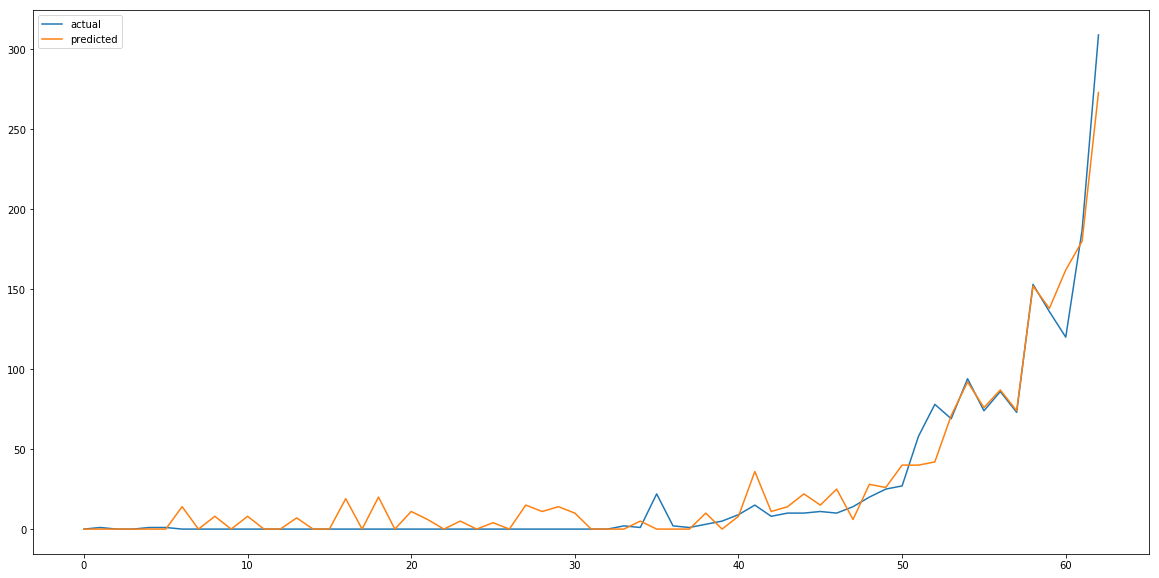

In [69]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas import DataFrame

def is_correct(value1, value2):
    correctness = False
    if value1 == value2:
        correctness = True
    elif abs(value1 - value2) <= 5:
        correctness = True
    elif value2 != 0 and value1/value2 <= 1.5 and value1/value2 >= (5/8):
        correctness = True
    return correctness

y_pred = model.predict(train_X, batch_size=batch_size)
i = 0

comparision_data = DataFrame()
correct = 0
total = 0
for x,y,actual in zip(train_X, y_pred,train_y):
    comparision_data.at[i,'Day']=i
    if y[0] < 0.0:
        y[0] = 0.0
    comparision_data.at[i,'Predicted'] = round(y[0]*1500)
    comparision_data.at[i,'Actual'] = (actual*1500)
    comparision_data.at[i,'State'] = 'Incorrect'
    if  is_correct(comparision_data.at[i,'Predicted'], comparision_data.at[i,'Actual']):
        correct+=1
        comparision_data.at[i,'State'] = 'Correct'
    total+=1
    i+=1

print(comparision_data)
print(correct/total)
plt.figure(figsize=(20,10))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(comparision_data['Actual'],label='actual')
plt.plot(comparision_data['Predicted'],label='predicted')
plt.legend()
plt.show()

In [68]:
# Test for April 1-15
df_test = pd.read_csv('../Timeseries-Data/test_data.csv')
columns_to_keep = ['Date','Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df_test = df_test.astype({"Population_Density":float ,"Lockdown": float,'Num_Cases':float,'Min_Temp':float,'Max_Temp':float})
df_test = df_test[columns_to_keep]

i=0
prev = 0.0
for ind in reversed(df_test.index):
    df_test.at[ind,'Min_Temp'] = (df_test.at[ind,'Min_Temp'] - temp_num)/temp_deno
    df_test.at[ind,'Max_Temp'] = (df_test.at[ind,'Max_Temp'] - temp_num)/temp_deno
    df_test.at[ind,'Lockdown'] = 1.0
    if ind != 0:
        df_test.at[ind,'Num_Cases'] -= df_test.at[ind-1,'Num_Cases']

df_test.at[0,'Num_Cases'] = 86
df_test['Num_Cases'] /= 1500

df_test = df_test.set_index('Date')

df_test

,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
Date,,,,,
3/25/2020,1.0,0.687500,0.875000,1.0,0.057333
3/26/2020,1.0,0.687500,0.833333,1.0,0.048667
3/27/2020,1.0,0.625000,0.708333,1.0,0.102000
3/28/2020,1.0,0.625000,0.833333,1.0,0.090667
3/29/2020,1.0,0.687500,0.833333,1.0,0.080000
3/30/2020,1.0,0.687500,0.833333,1.0,0.124667
3/31/2020,1.0,0.666667,0.854167,1.0,0.206000
4/1/2020,1.0,0.687500,0.916667,1.0,-1.090000
4/2/2020,1.0,0.687500,0.854167,1.0,0.000000


         Day  Predicted  Actual    State
0    1 April      310.0   424.0  Correct
1    2 April      331.0   486.0  Correct
2    3 April      366.0   560.0  Correct
3    4 April      385.0   579.0  Correct
4    5 April      400.0   605.0  Correct
5    6 April      521.0   489.0  Correct
6    7 April      590.0   573.0  Correct
7    8 April      631.0   565.0  Correct
8    9 April      676.0   813.0  Correct
9   10 April      673.0   871.0  Correct
10  11 April      696.0   854.0  Correct
11  12 April      746.0   751.0  Correct
12  13 April      894.0   961.0  Correct
13  14 April      922.0   834.0  Correct
14  15 April      942.0  1000.0  Correct
1.0


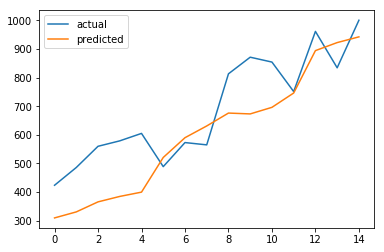

In [67]:
i = 0
comparision_data = DataFrame()
correct = 0
total = 0
df_actual = pd.read_csv("../Timeseries-Data/test_data.csv", index_col='Date')

df_actual = df_actual['3/31/2020':]
prev_date = '3/31/2020'
for _ in range(15):
    current_date = '4/'+str(i+1)+'/2020'
    actual = df_actual.at[current_date,'Actual_Num_Cases'] - df_actual.at[prev_date,'Actual_Num_Cases']
    prev_date = current_date
    df_partial = df_test['3/25/2020':current_date]
    df_partial_timeseries = series_to_supervised(df_partial,7,1,True)
    values = df_partial_timeseries.values
    test_x = values[-1:,:-1]
    test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    y_pred = model.predict(test_X, batch_size=batch_size)
    y = y_pred[0]
    x = test_X[0]
    comparision_data.at[i,'Day']=str(i+1)+' April'
    if y[0] < 0.0:
        y[0] = 0.0
    comparision_data.at[i,'Predicted'] = round(y[0]*1500)
    comparision_data.at[i,'Actual'] = actual
    comparision_data.at[i,'State'] = 'Incorrect'
    if is_correct(comparision_data.at[i,'Predicted'],comparision_data.at[i,'Actual']):
        correct+=1
        comparision_data.at[i,'State'] = 'Correct'
    total+=1
    df_test.at['4/'+str(i+1)+'/2020', 'Num_Cases'] = y[0]
    i+=1

print(comparision_data)
print(correct/total)
# plt.figure(figsize=(5,5))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(comparision_data['Actual'],label='actual')
plt.plot(comparision_data['Predicted'],label='predicted')
plt.legend()
plt.show()